<a href="https://colab.research.google.com/github/marcuschain-jpg/CSCI218_Proj_Wine_Quality-_ML/blob/main/CSCI218_GP_Red.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import files
import pandas as pd
import io

uploaded = files.upload()
raw_df = pd.read_csv(io.BytesIO(uploaded["winequality-red.csv"]), sep=";")

Saving winequality-red.csv to winequality-red.csv


In [ ]:
df = raw_df

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Balancing Dataset, Splitting & normalising
from imblearn.over_sampling import RandomOverSampler # Oversampling
from imblearn.over_sampling import SMOTE # Smote
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # Normalize
from scipy import stats

# Machine learning models
from sklearn.neural_network import MLPClassifier # MLP
from tqdm import tqdm #MLP
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import GradientBoostingClassifier # XGBoost

# Scoring systems
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1. Visualising Data
  - Check for duplicated rows
  - Check for skewness
  - See dataset

In [ ]:
display(df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
display(df.isnull().any())

,0
fixed acidity,False
volatile acidity,False
citric acid,False
residual sugar,False
chlorides,False
free sulfur dioxide,False
total sulfur dioxide,False
density,False
pH,False
sulphates,False


In [ ]:
print(df.duplicated().sum())

240


As seen there are some duplicated rows which presents noise to the data

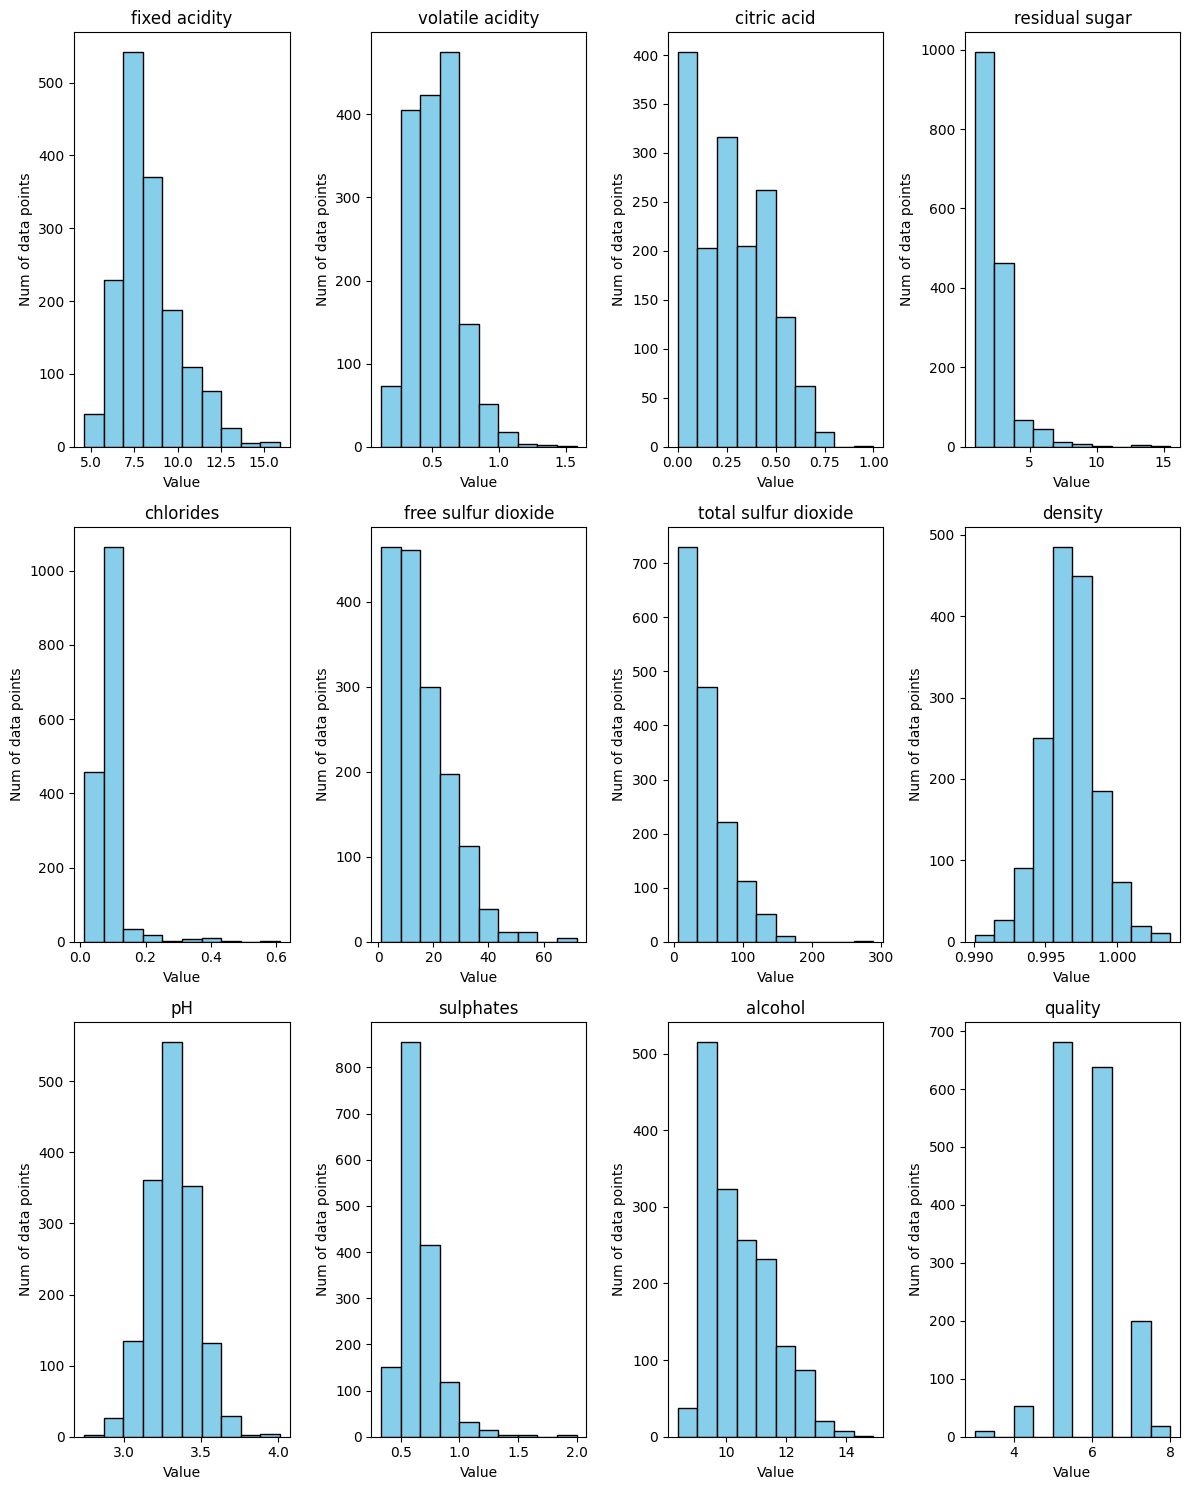

In [ ]:
# Check for skewness of features in DF with histogram
fig, axes = plt.subplots(3,4, figsize=(12,15))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    current_col = df.iloc[:, idx]
    ax.hist(current_col, bins=10, color='skyblue', edgecolor='black')
    ax.set_title(current_col.name)
    ax.set_xlabel('Value')
    ax.set_ylabel('Num of data points')

plt.tight_layout()
plt.show()

In [ ]:
skew = df.skew()
skew = skew[skew > 0.5]
skew_col = []
print(skew)

for col, value in skew.items():
  skew_col.append(col)

fixed acidity           0.982751
volatile acidity        0.671593
residual sugar          4.540655
chlorides               5.680347
free sulfur dioxide     1.250567
total sulfur dioxide    1.515531
sulphates               2.428672
alcohol                 0.860829
dtype: float64


As seen from above, from the histogram, the features all looks quite skewed, features like sulfur dioxide and chloride looks right skewed. Only features like density and PH have a normal distribution. To determine and fixed skew models, only skew of > 1 will log1p be performed on to fixed skewness of data

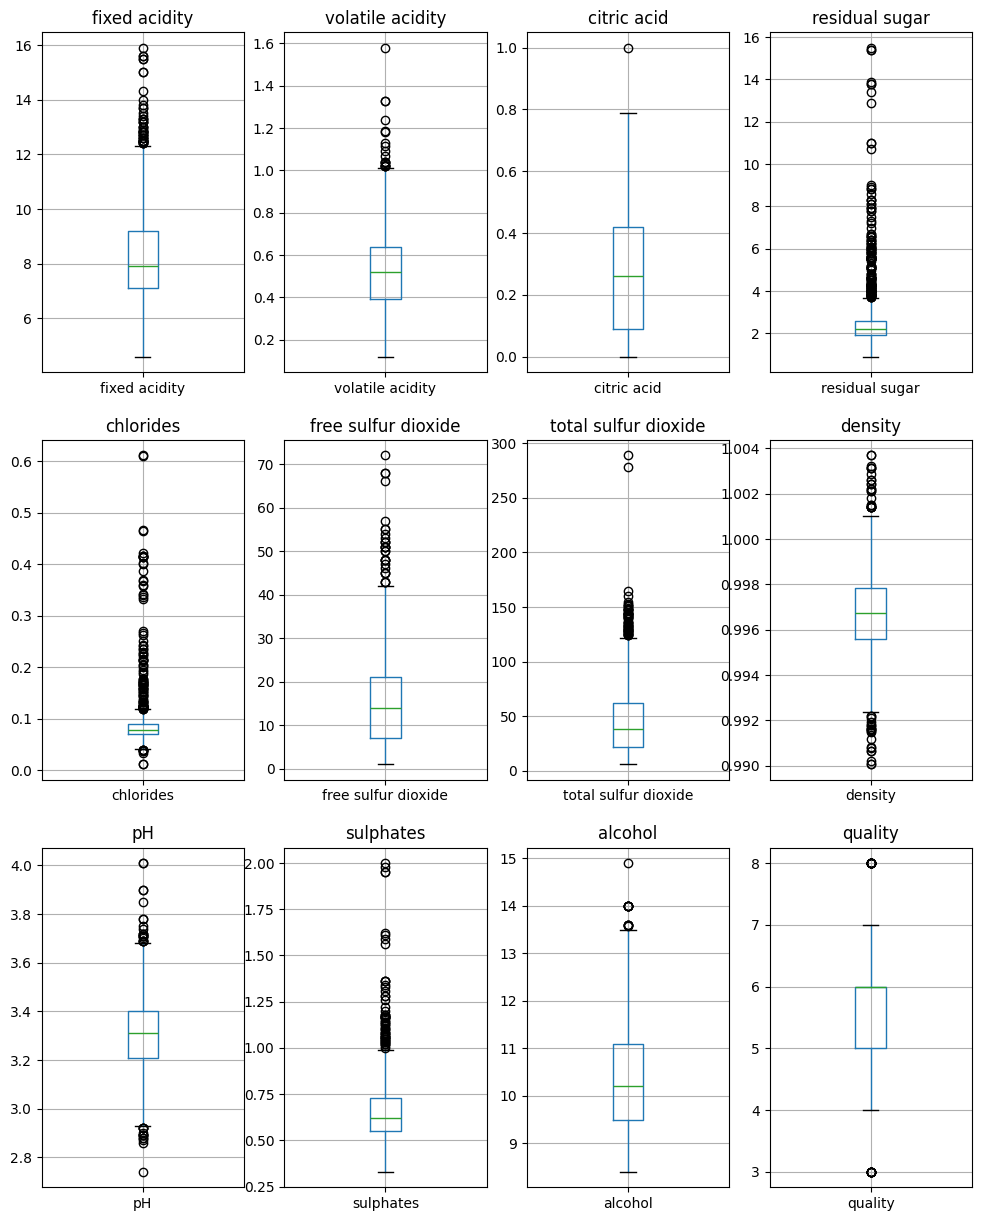

In [ ]:
# Check for outliers in DF
fig, axes = plt.subplots(3,4, figsize=(12,15))
axes = axes.flatten()

for idx, col in enumerate(df.columns):
  df.boxplot(column=col, ax=axes[idx])
  axes[idx].set_title(col)

As seen from the box and whiskers plot, there are many outliers in most features too. Hence to tackle this we are going to

# 2. Pre-processing of data

Based on the visualisation results, pre-processing of data will be performed to clean and transform data:
  1. Remove duplicate rows
  2. Fix Skewness
  3. Remove outliers
  4. Bin labels into Bad, Medium and Good quality
  5. Split Train - Test stratified sampling and split of (80% & 20&)
  6. Normalising all 11 feature values between 0 and 1

In [ ]:
# 1. Remove duplicate rows
df = df.drop_duplicates()

In [ ]:
# 2. Performing yeojohnson on right skewed features > 0.5 seen in df.skew()
for i in skew_col:
  if(i != 'quality'):
    df[i],_= stats.yeojohnson(df[i])

df.skew()

/tmp/ipython-input-3163077874.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i],_= stats.yeojohnson(df[i])


,0
fixed acidity,0.001884
volatile acidity,0.008311
citric acid,0.312726
residual sugar,-0.001715
chlorides,-0.061923
free sulfur dioxide,-0.009899
total sulfur dioxide,-0.003897
density,0.044778
pH,0.232032
sulphates,0.014637


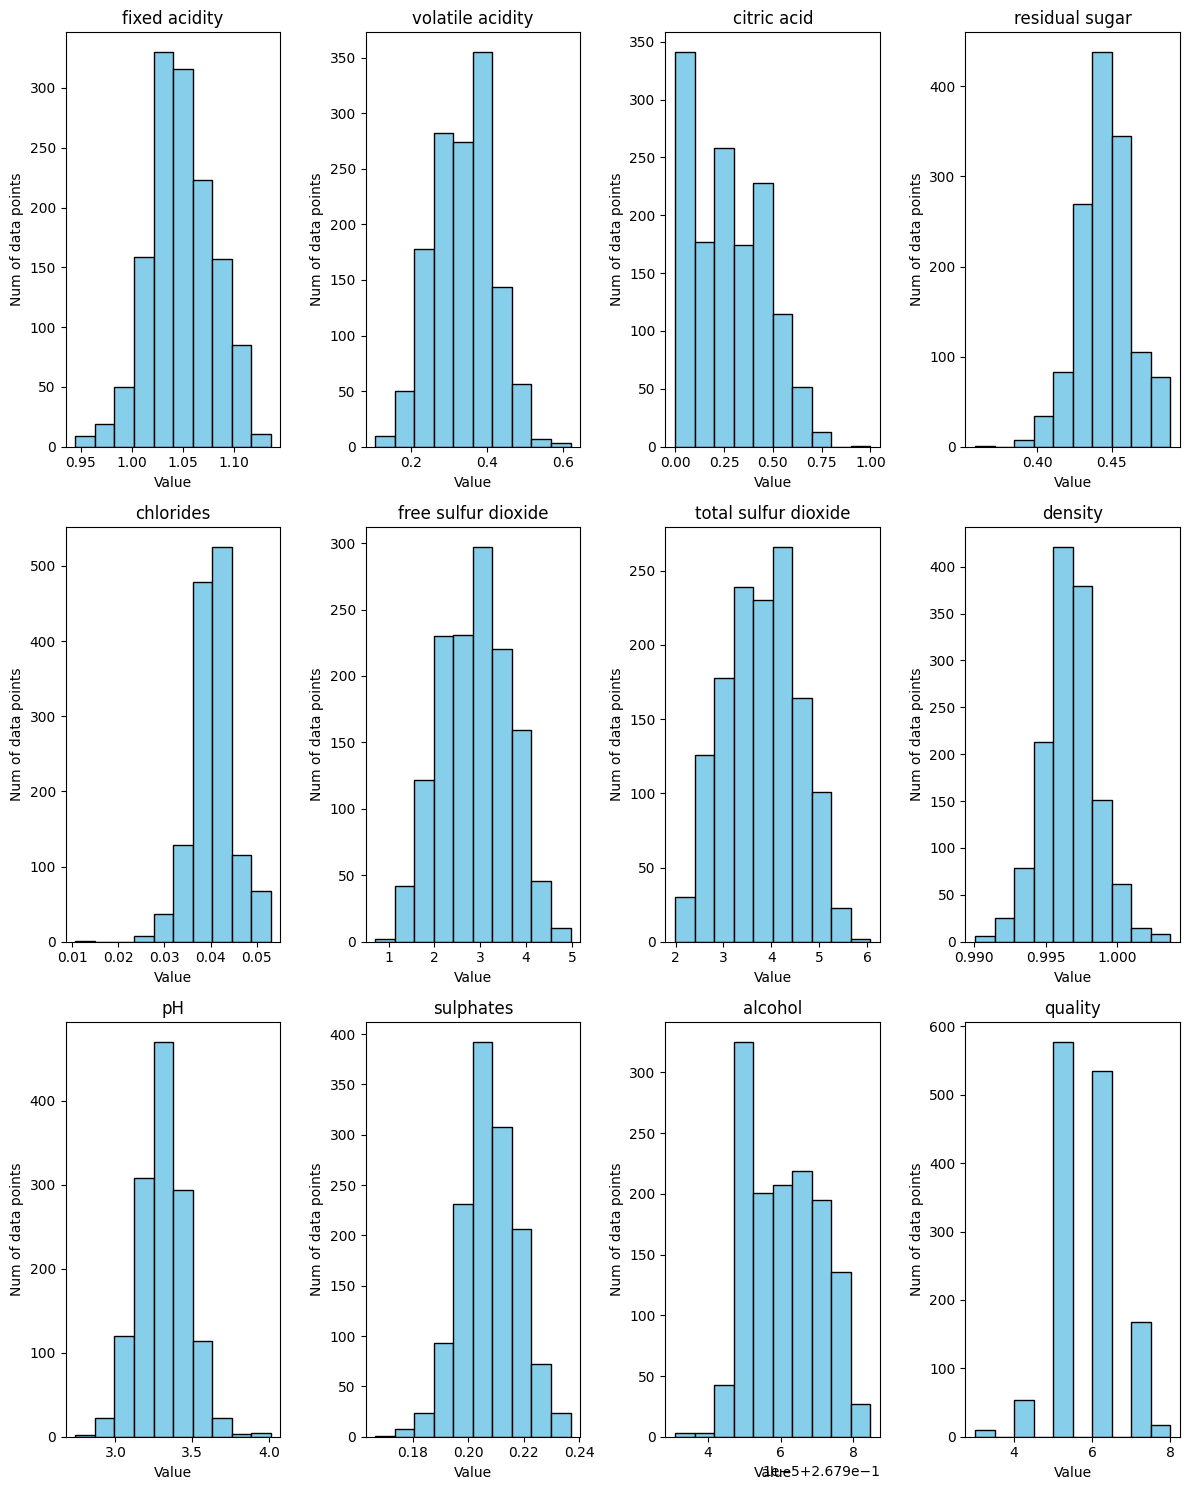

In [ ]:
# Check for skewness of features in DF with histogram
fig, axes = plt.subplots(3,4, figsize=(12,15))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    current_col = df.iloc[:, idx]
    ax.hist(current_col, bins=10, color='skyblue', edgecolor='black')
    ax.set_title(current_col.name)
    ax.set_xlabel('Value')
    ax.set_ylabel('Num of data points')

plt.tight_layout()
plt.show()

After applying boxcox on all right skewed features, it now looks more normally distributed

In [ ]:
# 3. Finding IQR and removing outliers
for i in df.columns:
  if  i != 'quality':
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3-Q1

    upperLimit = Q3 + 1.5 * IQR
    lowerLimit = Q1 - 1.5 * IQR

    df = df[(df[i] <= upperLimit) & (df[i] >= lowerLimit)]

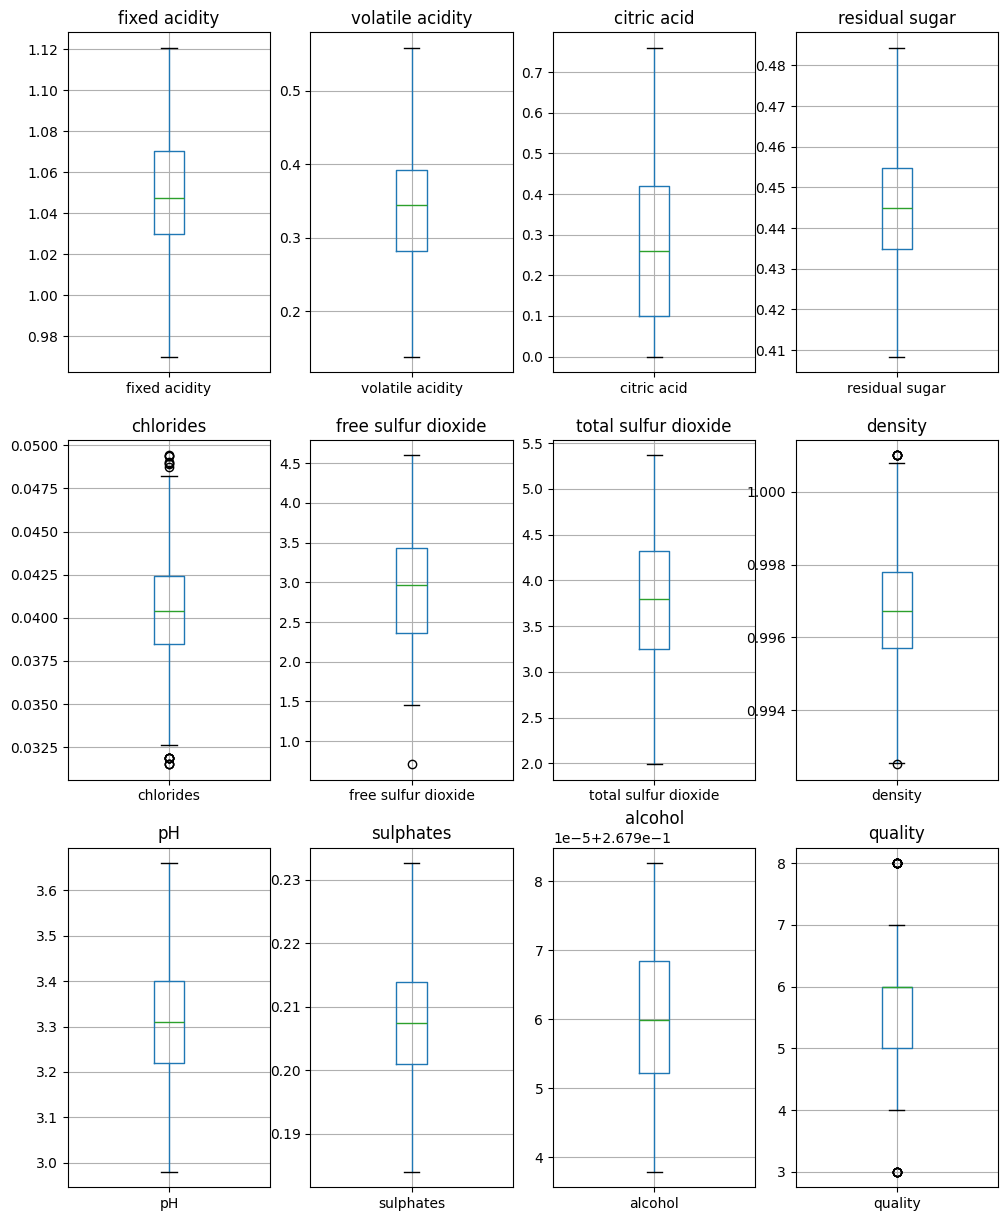

In [ ]:
# Check for outliers in DF
fig, axes = plt.subplots(3,4, figsize=(12,15))
axes = axes.flatten()

for idx, col in enumerate(df.columns):
  df.boxplot(column=col, ax=axes[idx])
  axes[idx].set_title(col)

Now there are little to none outliers

In [ ]:
# 4. Bin label into 3 numeric bins to signify (Bad, Medium, Good > 0, 1, 2):
df['quality'] = pd.cut(df['quality'], bins=[0,4,7,10], labels=[0,1,2])

In [ ]:
# 5. Split data, stratify to keep same class ratio in test and train set and sample train set to maintain equal labels disparity
x = df.drop('quality', axis = 1)
y = df['quality']
x = x.to_numpy()
y = y.to_numpy()

x_train_raw, x_test, y_train_raw, y_test = train_test_split(x, y, stratify=y, test_size=0.2)

# SMOTE sampling
smote = SMOTE(k_neighbors=3, random_state=42)
x_train, y_train = smote.fit_resample(x_train_raw, y_train_raw)

print(f'Length of train: {len(x_train)}')
print(f'Length of test: {len(x_test)}')

Length of train: 2658
Length of test: 235


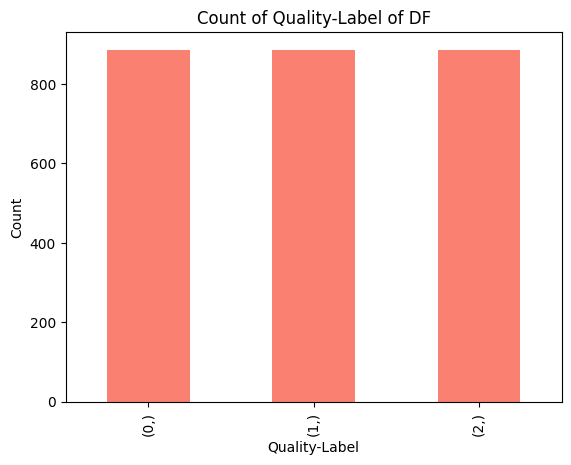

In [ ]:
# Get unique count of features and add missing feature values as 0
tempDF = pd.DataFrame(y_train)
labels_unique_count = tempDF.value_counts()
labels_unique_count = labels_unique_count.sort_index()

# Plot
labels_unique_count.plot(kind='bar', color='salmon')
plt.xlabel('Quality-Label')
plt.ylabel('Count')
plt.title("Count of Quality-Label of DF")
plt.show()

As seen above the minority classes are now oversampled for training data so that the model will not be biased towards any majority class. Now we normalize features so that it will reduce computational burden on ML models

In [ ]:
# 6. Normalize
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# 3. MLP Classifier training and fitting

After pre-processing of data, we will now train 3 Models, namely MLP, Random Forest & XGBoost and use it to predict the test set to see if the model can accurately predict 70% or more test samples correctly.

Goal: >= 70%

In [ ]:
print(len(x_train))
print(f'2/3 of input layer {(len(x_train)*(2/3))}')

2658
2/3 of input layer 1772.0


In [ ]:
n_hidden_1 = 2616
n_hidden_2 = 1300
n_hidden_3 = 500

n_hidden_options = [n_hidden_1,
                    (n_hidden_1, n_hidden_2),
                    (n_hidden_2, n_hidden_2),
                    (n_hidden_1, n_hidden_3),
                    (n_hidden_1, n_hidden_2, n_hidden_3)]

In [ ]:
best_tc = []
best_acc = 0
for test_case in tqdm(n_hidden_options):

    # STEP 5.1. Initialize an MLP classifier
    clf = MLPClassifier(hidden_layer_sizes=test_case, activation='relu', solver='adam', max_iter=1500,
                        random_state=42, early_stopping=True, learning_rate_init=0.01, alpha = 0.0005)

    # STEP 5.2. Fit the MLP to the training dataset
    clf.fit(x_train, y_train)

    # STEP 5.3. Evaluate its performance on the test dataset
    prediction = clf.predict(x_test)

    # STEP 5.4. Store the performance
    curr_acc = accuracy_score(y_test, prediction)
    if curr_acc > best_acc:
      best_acc = curr_acc
      best_tc = test_case

    current_loss = clf.loss_curve_[-1]
    tqdm.write(f"\nTest case: {test_case}\nTrain Loss: {current_loss:.4f}\nAccuracy: {curr_acc}")

 20%|██        | 1/5 [00:04<00:18,  4.58s/it]


Test case: 2616
Train Loss: 0.2001
Accuracy: 0.7872340425531915


 40%|████      | 2/5 [02:53<05:04, 101.46s/it]


Test case: (2616, 1300)
Train Loss: 0.0883
Accuracy: 0.8553191489361702


 60%|██████    | 3/5 [04:05<02:55, 87.87s/it] 


Test case: (1300, 1300)
Train Loss: 0.0944
Accuracy: 0.8851063829787233


 80%|████████  | 4/5 [05:01<01:15, 75.18s/it]


Test case: (2616, 500)
Train Loss: 0.1896
Accuracy: 0.8680851063829788


100%|██████████| 5/5 [09:05<00:00, 109.07s/it]


Test case: (2616, 1300, 500)
Train Loss: 0.2515
Accuracy: 0.9063829787234042


In [ ]:
clf2 = MLPClassifier(hidden_layer_sizes=best_tc, activation='relu', solver='adam', max_iter=1500,
                        random_state=42, early_stopping=True, learning_rate_init=0.01, alpha=0.0005)

# Train with train set
clf2.fit(x_train, y_train)
prediction = clf2.predict(x_test)

# Random Forest ML model

In [ ]:
RF_clf = RandomForestClassifier(n_estimators=100, max_depth=20, max_features=11, criterion='gini', random_state=42)
RF_clf.fit(x_train, y_train)
RF_pred = RF_clf.predict(x_test)

#XGBoost ML Model

In [ ]:
XG_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=20, max_features=11, random_state=42).fit(x_train, y_train)
XG_pred = XG_clf.predict(x_test)

#4. Review of Results

##Classification report of MLP

In [ ]:
LABEL_NAME = ['Bad', 'Medium', 'Good']
LABELS = np.unique(y_test)
LABELS = [str(x) for x in LABELS]
report = classification_report(y_test, prediction, target_names=LABEL_NAME)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         Bad       0.31      0.45      0.37        11
      Medium       0.96      0.94      0.95       222
        Good       0.00      0.00      0.00         2

    accuracy                           0.91       235
   macro avg       0.43      0.46      0.44       235
weighted avg       0.92      0.91      0.91       235



##Classification report of Random Forest

In [ ]:
LABEL_NAME = ['Bad', 'Medium', 'Good']
LABELS = np.unique(y_test)
LABELS = [str(x) for x in LABELS]
report = classification_report(y_test, RF_pred, target_names=LABEL_NAME)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         Bad       0.40      0.36      0.38        11
      Medium       0.96      0.95      0.96       222
        Good       0.20      0.50      0.29         2

    accuracy                           0.92       235
   macro avg       0.52      0.61      0.54       235
weighted avg       0.93      0.92      0.93       235



##Classifcation Report of XGBoost

In [ ]:
LABEL_NAME = ['Bad', 'Medium', 'Good']
LABELS = np.unique(y_test)
LABELS = [str(x) for x in LABELS]
report = classification_report(y_test, XG_pred, target_names=LABEL_NAME)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         Bad       0.19      0.27      0.22        11
      Medium       0.95      0.93      0.94       222
        Good       0.00      0.00      0.00         2

    accuracy                           0.89       235
   macro avg       0.38      0.40      0.39       235
weighted avg       0.91      0.89      0.90       235



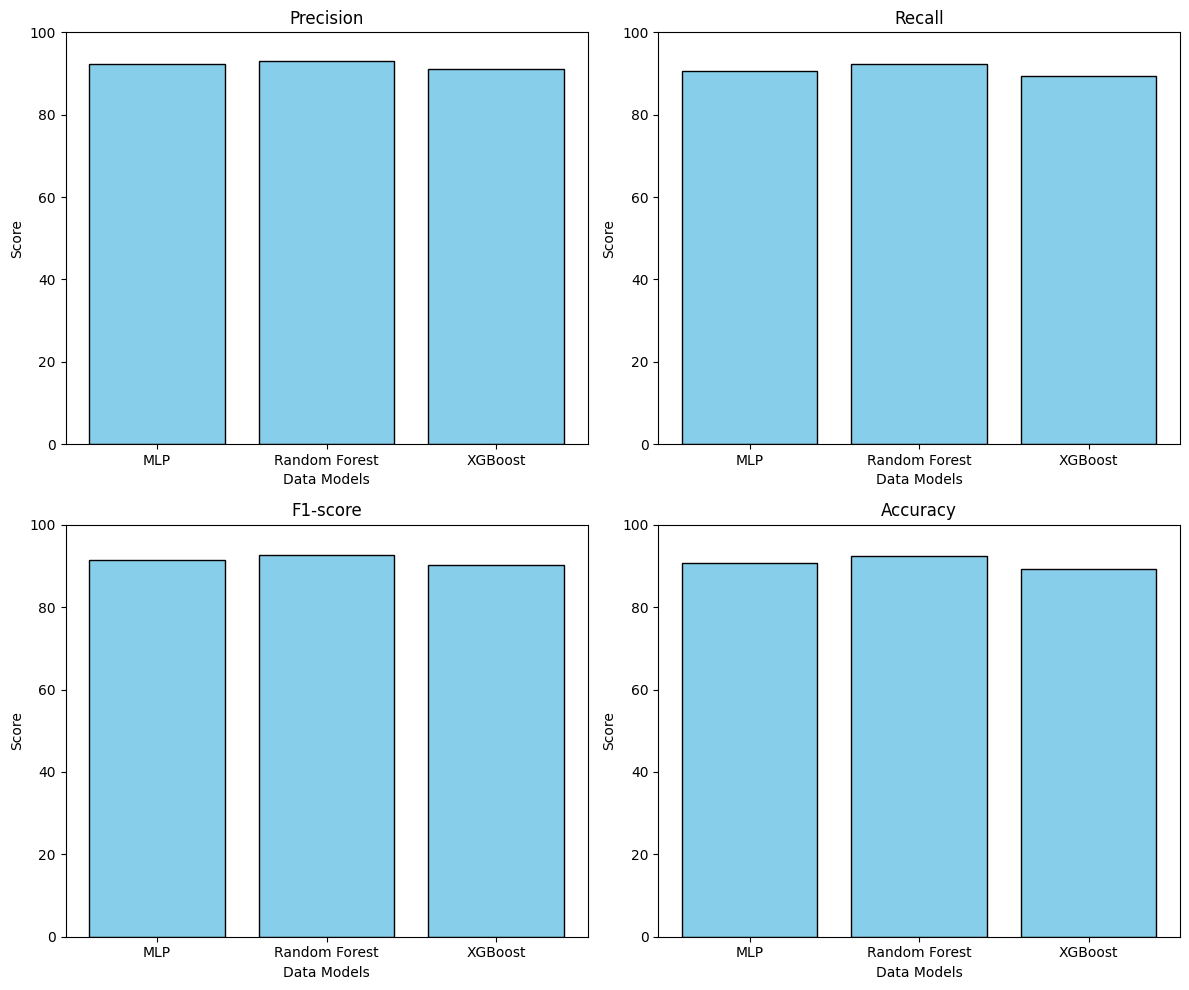

In [ ]:
# Get results
models = ['MLP', 'Random Forest', 'XGBoost']
model_prediction = [prediction, RF_pred, XG_pred]
metric_name = ['Precision', 'Recall', 'F1-score', 'Accuracy']

precision = []
recall = []
f1 = []
accuracy = []
metric = []

for i in model_prediction:
  precision.append(round((precision_score(y_test, i, average='weighted', zero_division=0)*100), 2))
  recall.append(round((recall_score(y_test, i, average='weighted', zero_division=0)*100), 2))
  f1.append(round((f1_score(y_test, i, average='weighted', zero_division=0)*100), 2))
  accuracy.append(round((accuracy_score(y_test, i)*100),2))
metric = [precision, recall, f1, accuracy]

#Plot results in chart
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    ax.bar(models, metric[idx], color='skyblue', edgecolor='black')
    ax.set_title(metric_name[idx])
    ax.set_xlabel('Data Models')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

As seen from the chart above, XGBoost is the best at predicting the quality of red wine as its average statistics are the highest among all models.